# Frame the problem
1. What will the customer spend in the next 90 days (Regression)
2. What is the probability of a customer to make a purchase in the next 90 days (Classification)

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="dark")
import numpy as np
from scipy import stats
from datetime import datetime

In [73]:
df = pd.read_parquet("ecomm_invoice_transaction.parquet")
print(f"data shape: {df.shape}")
df.head()

data shape: (541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [74]:
df[df["total_spend"] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,2010-12-01 11:52:00,0.0,0,United Kingdom,0.0
1970,536545,21134,No Description,1,2010-12-01 14:32:00,0.0,0,United Kingdom,0.0
1971,536546,22145,No Description,1,2010-12-01 14:33:00,0.0,0,United Kingdom,0.0
1972,536547,37509,No Description,1,2010-12-01 14:33:00,0.0,0,United Kingdom,0.0
1987,536549,85226A,No Description,1,2010-12-01 14:34:00,0.0,0,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
536981,581234,72817,SET OF 2 CHRISTMAS DECOUPAGE CANDLE,27,2011-12-08 10:33:00,0.0,0,United Kingdom,0.0
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,0,United Kingdom,0.0
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,0,United Kingdom,0.0
538554,581408,85175,CACTI T-LIGHT CANDLES,20,2011-12-08 14:06:00,0.0,0,United Kingdom,0.0


# 1. Exploratory Data Analysis(EDA)

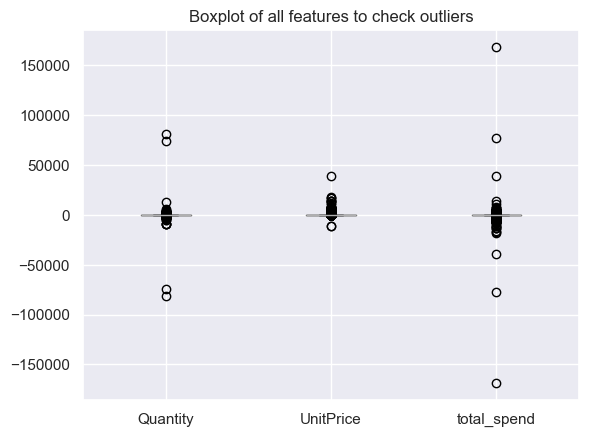

In [41]:
df.drop(columns=['CustomerID']).boxplot()
plt.title("Boxplot of all features to check outliers")
plt.show()

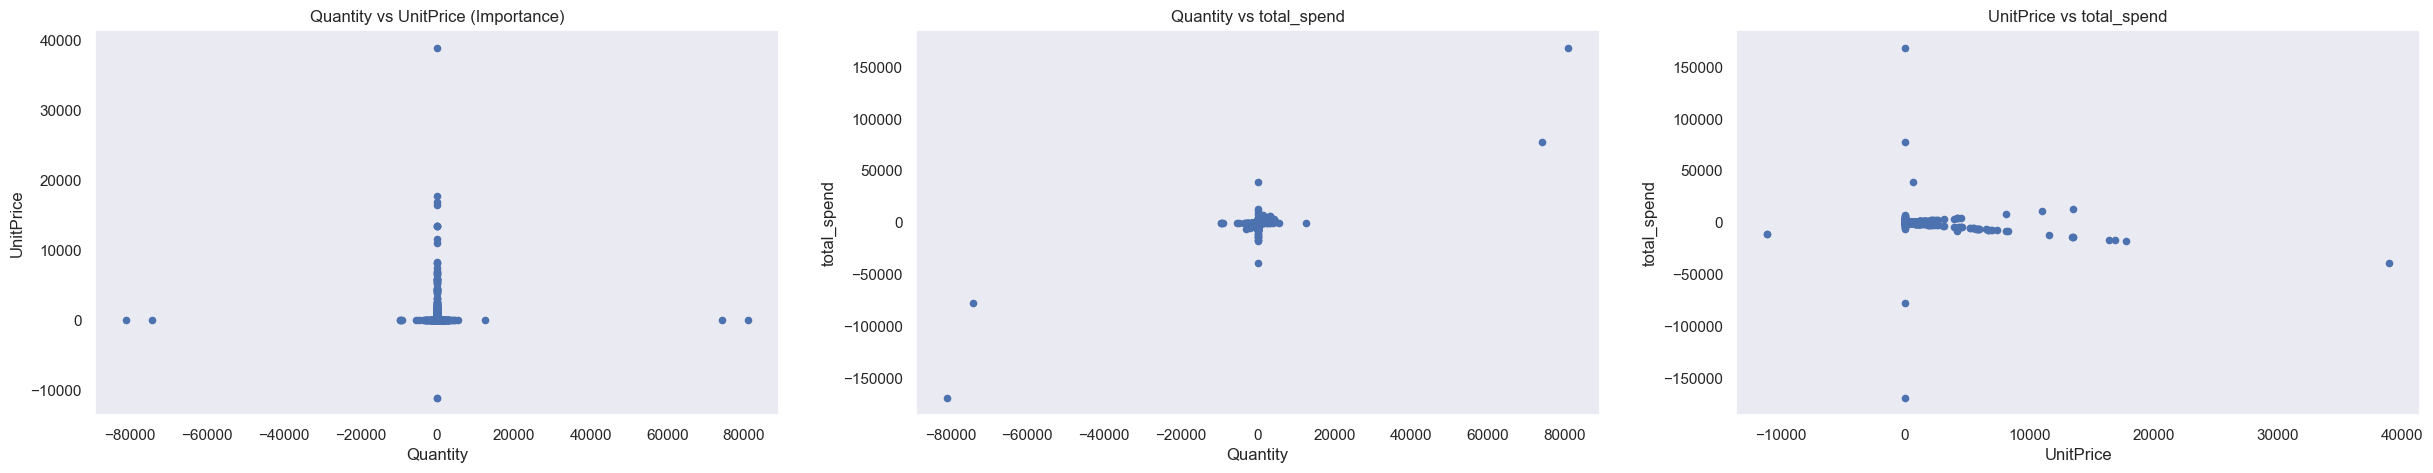

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(30,5))
data = [(df['Quantity'], df['UnitPrice'], 'Quantity vs UnitPrice (Importance)', 'Quantity', 'UnitPrice'),
        (df['Quantity'], df['total_spend'], 'Quantity vs total_spend', 'Quantity', 'total_spend'),
        (df['UnitPrice'], df['total_spend'], 'UnitPrice vs total_spend', 'UnitPrice', 'total_spend')]

# Plot each scatter plot
for i, (x, y, title, xlabel, ylabel) in enumerate(data):
    ax[i].scatter(x=x, y=y, s=20)
    ax[i].set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

In [43]:
def remove_outlier(df: pd.DataFrame, iqr_column: str, zscore_column: str):
    # IQR method for Quantity column
    Q1 = df[iqr_column].quantile(0.25)
    Q3 = df[iqr_column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df[iqr_column]>=upper)[0]
    lower_array = np.where(df[iqr_column]<=lower)[0]

    # Removing the outliers by IQR method
    df = df.drop(index=upper_array)
    df = df.drop(index=lower_array)

    # Z-score method for UnitPrice column
    z = np.abs(stats.zscore(df[zscore_column])) 
    threshold = 3
    # outliers = np.where(z > threshold)

    # DataFrame with no oulier
    df = df[(z < threshold)]

    return df

In [44]:
df = remove_outlier(df=df, iqr_column='Quantity', zscore_column='UnitPrice')
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(482948, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [45]:
defect_index = df[(df['Quantity'] < 0) | (df['UnitPrice'] == 0)].index
df = df.drop(index=defect_index)
df = df.reset_index(drop=True)
print(f"datashape: {df.shape}")
df.head()

datashape: (473536, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


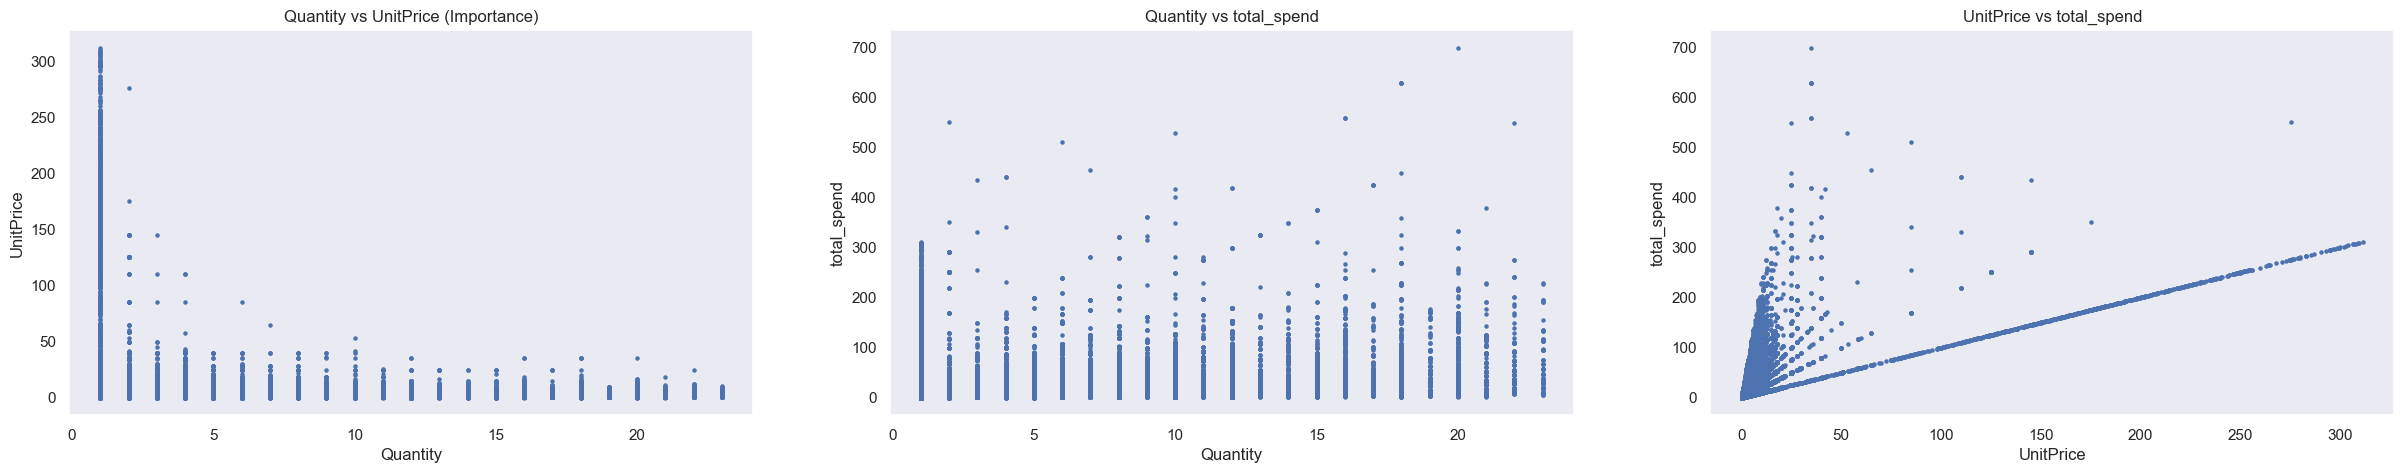

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(30,5))
data = [(df['Quantity'], df['UnitPrice'], 'Quantity vs UnitPrice (Importance)', 'Quantity', 'UnitPrice'),
        (df['Quantity'], df['total_spend'], 'Quantity vs total_spend', 'Quantity', 'total_spend'),
        (df['UnitPrice'], df['total_spend'], 'UnitPrice vs total_spend', 'UnitPrice', 'total_spend')]

# Plot each scatter plot
for i, (x, y, title, xlabel, ylabel) in enumerate(data):
    ax[i].scatter(x=x, y=y, s=5)
    ax[i].set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

# 2.Feature engineering

### RFM feature

In [47]:
# df.shape = 473,536 x 9
# show anonymous customer 
df[(df['CustomerID']==0)]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
1222,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,0,United Kingdom,2.51
1223,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,0,United Kingdom,5.02
1224,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,0,United Kingdom,3.40
1225,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,0,United Kingdom,3.32
1226,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,0,United Kingdom,14.94
...,...,...,...,...,...,...,...,...,...
473230,581498,85049E,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,0,United Kingdom,13.16
473231,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,0,United Kingdom,20.65
473232,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,0,United Kingdom,16.52
473233,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,0,United Kingdom,4.96


In [48]:
sample = df.copy()

In [49]:
freq = sample.groupby(['CustomerID'])["InvoiceNo"].nunique().reset_index().rename({"InvoiceNo":'Frequency'},axis = 1)
freq.head()

,CustomerID,Frequency
0,0,1395
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [50]:
monetary = sample.groupby('CustomerID')["total_spend"].sum().reset_index().rename({'total_spend': 'monetary'}, axis=1)
monetary.head()

,CustomerID,monetary
0,0,1266656.86
1,12347,3097.82
2,12348,377.00
3,12349,1626.15
4,12350,314.00


In [51]:
sample["InvoiceDate"] = pd.to_datetime(sample["InvoiceDate"])

In [52]:
recency = sample.groupby("CustomerID")["InvoiceDate"].max().reset_index()
max_date = sample["InvoiceDate"].max()
recency["InvoiceDate"] = max_date - recency['InvoiceDate']
recency["InvoiceDate"] = recency["InvoiceDate"].dt.days
recency = recency.rename({"InvoiceDate":"Recency"},axis = 1)


In [53]:
max_date

Timestamp('2011-12-09 12:50:00')

In [54]:
recency

,CustomerID,Recency
0,0,0
1,12347,1
2,12348,74
3,12349,18
4,12350,309
...,...,...
4205,18280,277
4206,18281,180
4207,18282,7
4208,18283,3


In [55]:
customer_profile = recency.merge(freq,on = 'CustomerID').merge(monetary,on = "CustomerID")
customer_profile.head()

,CustomerID,Recency,Frequency,monetary
0,0,0,1395,1266656.86
1,12347,1,7,3097.82
2,12348,74,4,377.00
3,12349,18,1,1626.15
4,12350,309,1,314.00


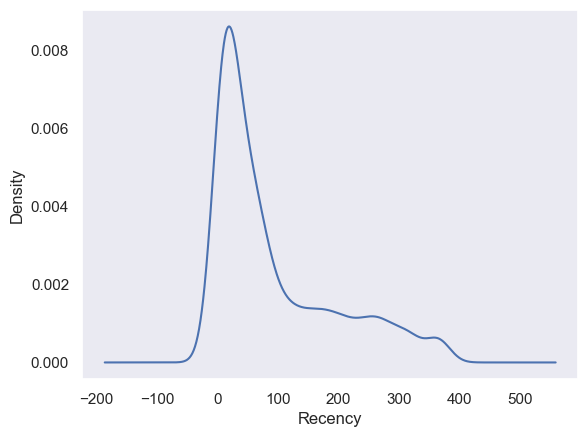

           Recency    Frequency      monetary
count  4210.000000  4210.000000  4.210000e+03
mean     92.042280     4.358195  1.383696e+03
std     100.238504    22.567119  1.965131e+04
min       0.000000     1.000000  1.900000e+00
25%      17.000000     1.000000  2.223025e+02
50%      50.000000     2.000000  5.074750e+02
75%     144.000000     4.000000  1.173950e+03
max     373.000000  1395.000000  1.266657e+06


In [56]:
customer_profile['Recency'].plot(kind='kde')
plt.xlabel('Recency')
plt.show()
print(customer_profile.drop(columns=['CustomerID']).describe())

1. if you want to get more money you should focus on the one that spend the most 
2. if you want to retain customer you need to increase recency of transaction and increase frequency of transaction

In [125]:
df = pd.read_parquet("ecomm_invoice_transaction.parquet")

In [126]:
df.loc[df["total_spend"] < 0, "total_spend"] = 0

In [127]:
n_days = 90
max_date = df['InvoiceDate'].max()
cutoff = max_date - pd.to_timedelta(n_days,unit = "d")
temporal_in_df = df[df['InvoiceDate'] <= cutoff] # == 0 (7865), >0 (326,189)
temporal_out_df = df[df['InvoiceDate']>= cutoff] # == 0 (683), >0 (203,915)



In [130]:
# shape 
frequency_features_90 = temporal_in_df.groupby(['CustomerID'])["InvoiceNo"].nunique().reset_index().rename({"InvoiceNo":'Frequency'},axis = 1)

In [149]:
monetary_features_90 = temporal_in_df.groupby('CustomerID')['total_spend'].sum().reset_index().rename(columns={'total_spend': 'Monetary_sum'})
monetary_features_90["Monetary_mean"] = temporal_in_df.groupby('CustomerID')['total_spend'].mean().reset_index().rename(columns={'total_spend': 'monetary'})['monetary']


In [135]:
recency_features_90 = temporal_in_df.groupby("CustomerID")["InvoiceDate"].max().reset_index()
max_date = temporal_in_df["InvoiceDate"].max()
recency_features_90["InvoiceDate"] = max_date - recency_features_90['InvoiceDate']
recency_features_90["InvoiceDate"] = recency_features_90["InvoiceDate"].dt.days
recency_features_90 = recency_features_90.rename({"InvoiceDate":"Recency"},axis = 1)

### Create Label for regression

In [137]:
targets_df_reg = temporal_out_df.groupby('CustomerID')['total_spend'].sum().reset_index().rename({'total_spend':'Spend_90_total'},axis = 1)


In [143]:
targets_df_reg['Label'] = (targets_df_reg['Spend_90_total'] > 0).astype(int)
len(targets_df_reg)


2919

In [144]:
targets_df_reg

,CustomerID,Spend_90_total,Label
0,0,651852.00,1
1,12347,1519.14,1
2,12348,310.00,1
3,12349,1757.55,1
4,12352,944.23,1
...,...,...,...
2914,18277,110.38,1
2915,18278,173.90,1
2916,18282,77.84,1
2917,18283,974.21,1


In [141]:
len(targets_df_reg[targets_df_reg['Label']==0])

29

In [170]:
features_90 = pd.concat([recency_features_90,frequency_features_90,monetary_features_90],axis = 1)\
    .merge(targets_df_reg,
           left_index = True,
           right_index = True,
           how = "left").fillna(0)

In [171]:
features_90 = features_90.loc[:,~features_90.columns.duplicated()]

In [174]:
features_90.columns_name

,CustomerID_x,Recency,Frequency,Monetary_sum,Monetary_mean,CustomerID_y,Spend_90_total,Label
0,0,0,2682,1103424.64,12.003270,0.0,651852.00,1.0
1,12346,234,2,77183.60,38591.800000,12347.0,1519.14,1.0
2,12347,38,5,2790.86,22.506935,12348.0,310.00,1.0
3,12348,157,3,1487.24,53.115714,12349.0,1757.55,1.0
4,12350,219,1,334.40,19.670588,12352.0,944.23,1.0
...,...,...,...,...,...,...,...,...
3408,18280,186,1,180.60,18.060000,0.0,0.00,0.0
3409,18281,89,1,80.82,11.545714,0.0,0.00,0.0
3410,18282,31,2,100.21,12.526250,0.0,0.00,0.0
3411,18283,4,10,1120.67,2.507092,0.0,0.00,0.0


# 3. Machine Learning 

## 3.1 Regression 

In [154]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
X_reg= features_90[['Recency','Frequency','Monetary_sum','Monetary_mean']]

In [155]:
y_reg = features_90[['Spend_90_total']]

In [156]:
xgb_reg = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 42
)
xgb_reg_model = GridSearchCV(
    estimator = xgb_reg,
    param_grid = dict(
        learning_rate = [0.01,0.1,0.3,0.5]
    ),
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5   
)

In [157]:
xgb_reg_model.fit(X_reg,y_reg)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [158]:
xgb_reg_model.best_score_

-1352.6600634747738

In [159]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [160]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [161]:
prediction_reg = xgb_reg_model.predict(X_reg)

In [165]:
features_90

,CustomerID_x,Recency,CustomerID_x,Frequency,CustomerID_x,Monetary_sum,Monetary_mean,CustomerID_y,Spend_90_total,Label
0,0,0,0,2682,0,1103424.64,12.003270,0.0,651852.00,1.0
1,12346,234,12346,2,12346,77183.60,38591.800000,12347.0,1519.14,1.0
2,12347,38,12347,5,12347,2790.86,22.506935,12348.0,310.00,1.0
3,12348,157,12348,3,12348,1487.24,53.115714,12349.0,1757.55,1.0
4,12350,219,12350,1,12350,334.40,19.670588,12352.0,944.23,1.0
...,...,...,...,...,...,...,...,...,...,...
3408,18280,186,18280,1,18280,180.60,18.060000,0.0,0.00,0.0
3409,18281,89,18281,1,18281,80.82,11.545714,0.0,0.00,0.0
3410,18282,31,18282,2,18282,100.21,12.526250,0.0,0.00,0.0
3411,18283,4,18283,10,18283,1120.67,2.507092,0.0,0.00,0.0


In [167]:
prediction_reg = pd.concat([prediction_reg,features_90['CustomerID_x']],axis = 1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid